---
layout: default
title: Citation Analysis
parent: OpenAlex
nav_order: 1
---

# Citation Analysis

The ability to perform in-depth citation analysis using OpenAlex's user interface is limited. By developing scripts that can gather results that cite, or are cited by, a set of publications, we enable a variety of approaches to research impact assessment and bibliometric analysis.  

In this notebook, we will query the OpenAlex API to answer the following questions:  

1. **How many works has a researcher (or a group of researchers) published?**
2. **How many citations has a researcher (or a group of researchers) received in a given year?**
3. **What are the most influential publications in a given research area? _(backward citation analysis)_**
4. **Which countries/journals/authors cite my research most often? _(forward citation analysis)_**
5. **How do citation rates differ between my organization's open access vs. non-open access publications?**

## Assessing Citation/Work Counts of Researcher

This can help an organization, department, or research institute track the citation rates of their researchers over time (an indicator of research engagement/impact).  

### Steps

Let's start by dividing the process into smaller, more manageable steps:  

1. We need to get all the works published by the researcher
2. We group the publications by year
3. We count the total numbers of publications and citations each year

### Input

The only input we need is an identifier of the researcher in question and we opted for the researcher's OpenAlex ID. We can look up the OpenAlex ID of the researcher by searching the name of the researcher in the [OpenAlex landing page](https://openalex.org/).  

In [1]:
SAVE_CSV = False  # flag to determine whether to save the output as a CSV file 
FIRST_NUM_ROWS = 25  # number of top items to display

# input
author_id = "https://openalex.org/A5075441180"

### Get all works published by researcher

The first step is to build the query URL to get the data we need. In this case, we will use the [`works`](https://docs.openalex.org/api-entities/works) entity type.  

> While [`authors`](https://docs.openalex.org/api-entities/authors) entity type offers direct access to citation and work metrics, we discoverd significant discrepencies between this aggregated author data and the data available on a work-by-work basis. After consulting with OpenAlex, we decided the most accurate approach (at the time of the writing of this notebook) would be to gather the data avaiable at the works level and aggregate this data ourselves.  

Our search criteria are as follows:  
- [`author.id`](https://docs.openalex.org/api-entities/works/work-object/authorship-object#author): Author of a work (OpenAlex ID), `author.id:https://openalex.org/A5075441180`

Now we need to put the URL together from the following parameters:  
- Starting point is the base URL of the OpenAlex API: `https://api.openalex.org/`
- We append the entity type to it: `https://api.openalex.org/works`
- All criteria need to go into the query parameter filter that is added after a question mark: `https://api.openalex.org/works?filter=`
- To construct the filter value we take the criteria we specified and concatenate them using commas as separators: `https://api.openalex.org/works?filter=author.id:https://openalex.org/A5075441180&page=1&per-page=50`
    - `page` and `per-page` are parameters for [pagination](https://docs.openalex.org/how-to-use-the-api/get-lists-of-entities/paging). Sometimes a query result is too big, it is a technique to break down the results and allow users to retrieve all the data in separate queries. 

In [2]:
import requests
import pandas as pd


def get_works_by_author(author_id, page=1, items_per_page=50):
    # construct the api url with the given author id, page number, and items per page
    url = f"https://api.openalex.org/works?filter=author.id:{author_id}&page={page}&per-page={items_per_page}"

    # send a GET request to the api and parse the json response
    response = requests.get(url)
    json_data = response.json()

    # convert the json response to a dataframe
    df_json = pd.DataFrame.from_dict(json_data["results"])

    next_page = True
    if df_json.empty: # check if the dataframe is empty (i.e., no more pages available)
        next_page = False

    # if there are more pages, recursively fetch the next page
    if next_page:
        df_json_next_page = get_works_by_author(author_id, page=page+1, items_per_page=items_per_page)
        df_json = pd.concat([df_json, df_json_next_page])

    return df_json

In [3]:
def get_work_counts_by_year(df, author_id):
    # check if the dataframe is empty or if 'publication_year' column is missing
    if df.empty or "publication_year" not in df.columns:
        return pd.DataFrame()

    # count the occurrences of each publication year and convert to a dictionary
    results = df["publication_year"].value_counts().to_dict()

    # create a dictionary with counts by year
    records = {"counts_by_year": [{'year': year, 'works_by_count': count} for year, count in results.items()]}

    # normalize the json data to create a dataframe
    df_normalized = pd.json_normalize(records, "counts_by_year", [])

    # group by year and sum the work counts
    df_works = df_normalized.groupby(["year"])["works_by_count"].sum()

    # reset the index to convert the series to a dataframe
    df_works = df_works.reset_index()

    # add the 'author_id' to the dataframe
    df_works["id"] = author_id

    # pivot the dataframe to have years as columns and works count as values
    df_works = df_works.pivot(index=["id"], columns="year", values=["works_by_count"])

    return df_works

In [4]:
def get_cited_by_counts_by_year(df, author_id):
    # check if the dataframe is empty or if required columns are missing
    if df.empty or "id" not in df.columns or "counts_by_year" not in df.columns:
        return pd.DataFrame()

    # convert the relevant columns to a list of dictionaries
    records = df[["id", "counts_by_year"]].to_dict("records")

    # normalize the json data to create a dataframe
    df_normalized = pd.json_normalize(records, "counts_by_year", [])

    # group by year and sum the citation counts
    df_citations = df_normalized.groupby(["year"])["cited_by_count"].sum()

    # reset the index to convert the series to a dataframe
    df_citations = df_citations.reset_index()

    # add the 'author_id' to the dataframe
    df_citations["id"] = author_id

    # pivot the dataframe to have years as columns and citation count as values
    df_citations = df_citations.pivot(index=["id"], columns="year", values=["cited_by_count"])

    return df_citations

In [5]:
df_works = get_works_by_author(author_id)
if SAVE_CSV:
    df_works.to_csv(f"author_works.csv", index=True)

In [6]:
df_works_by_year = get_work_counts_by_year(df_works, author_id)

# reindex the dataframe columns in sorted order
df_works_by_year = df_works_by_year.reindex(sorted(df_works_by_year.columns), axis=1)

# group the dataframe by 'id' and sum the values
df_works_by_year = df_works_by_year.groupby(["id"]).sum()

# flatten the multiple index columns to a single level
df_works_by_year.columns = df_works_by_year.columns.get_level_values(1)

# reset the index to convert the 'id' index back to a column
df_works_by_year = df_works_by_year.reset_index()

### Work counts by year

Here, we create a dataframe that displays the researcher's publications (by year).  

In [7]:
if SAVE_CSV:
    df_works_by_year.to_csv(f"work_counts_by_year.csv", index=True)

df_works_by_year

year,id,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022,2023
0,https://openalex.org/A5075441180,1,4,5,3,2,2,6,4,4,16,10,8,6,12,6,1,1


In [8]:
df_citations_by_year = get_cited_by_counts_by_year(df_works, author_id)

# reindex the dataframe columns in sorted order
df_citations_by_year = df_citations_by_year.reindex(sorted(df_citations_by_year.columns), axis=1)

# group the dataframe by 'id' and sum the values
df_citations_by_year = df_citations_by_year.groupby(["id"]).sum()

# flatten the multiindex columns to a single level
df_citations_by_year.columns = df_citations_by_year.columns.get_level_values(1)

# reset the index to convert the 'id' index back to a column
df_citations_by_year = df_citations_by_year.reset_index()

### Citation counts by year

Here, we create a dataframe that displays citations to the researcher's publications (by year).  

In [9]:
if SAVE_CSV:
    df_citations_by_year.to_csv(f"citation_counts_by_year.csv", index=True)

df_citations_by_year

year,id,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022,2023,2024,2025
0,https://openalex.org/A5075441180,24,24,40,29,50,45,52,38,92,332,454,441,451,64


## Backward Citation Analysis

This approach can be used to identify the body of literature that has influenced a given work or set of works. In this example, we explore the body of literature influencing the individual researcher from above (but this analysis could also be performed at the topic-, journal-, or organizational-level).  

### Steps

1. We need to get all the works published by the researcher
2. We get all the outgoing referenced works
3. We examine the occurrence of references in all works published by the researcher

### Get all outgoing referenced works

Our search criteria are as follows:  
- [`cited_by`](https://docs.openalex.org/api-entities/works/filter-works#cited_by): works found in the given work's [`referenced_works`](https://docs.openalex.org/api-entities/works/work-object#referenced_works) section, `cited_by:https://openalex.org/W2766808518`

Now we need to build an URL for the query from the following parameters:  
- Starting point is the base URL of the OpenAlex API: `https://api.openalex.org/`
- We append the entity type to it: `https://api.openalex.org/works`
- All criteria need to go into the query parameter filter that is added after a question mark: `https://api.openalex.org/works?filter=`
- To construct the filter value we take the criteria we specified and concatenate them using commas as separators: `https://api.openalex.org/works?filter=cited_by:https://openalex.org/W2766808518&page=1&per-page=50`

In [10]:
def get_all_outgoing_referenced_works(work_ids):

    def get_outgoing_referenced_work(work_id, page=1, items_per_page=50):
        # construct the api url with the given work id, page number, and items per page
        url = f"https://api.openalex.org/works?filter=cited_by:{work_id}&page={page}&per-page={items_per_page}"

        # send a GET request to the api and parse the json response
        response = requests.get(url)
        json_data = response.json()

        # convert the json response to a dataframe
        df_json = pd.DataFrame.from_dict(json_data["results"])

        next_page = True
        if df_json.empty: # check if the dataframe is empty (i.e., no more pages available)
            next_page = False

        # if there are more pages, recursively fetch the next page
        if next_page:
            df_json_next_page = get_outgoing_referenced_work(work_id, page=page+1, items_per_page=items_per_page)
            df_json = pd.concat([df_json, df_json_next_page])

        # add the 'work_id' to the dataframe
        df_json["original_work"] = work_id
        return df_json

    df_reference = pd.concat(map(get_outgoing_referenced_work, work_ids))
    return df_reference

In [11]:
df_outgoing_reference = get_all_outgoing_referenced_works(df_works["id"])
if SAVE_CSV:
    df_outgoing_reference.to_csv(f"outgoing_referenced.csv", index=True)

/var/folders/90/d4l4r4497dzbtl64rn9vp0gr0000gn/T/ipykernel_90481/2492055361.py:21: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_json = pd.concat([df_json, df_json_next_page])


### Examine occurrence of outgoing referenced publication

Here, we create a dataframe displaying the number of times the researcher has cited each work.  


In [12]:
# group the dataframe by 'id' and 'title', and aggregate the 'id' column by count
df_unique_outgoing_reference = df_outgoing_reference.groupby(["id", "title"]).agg({"id": "count"})

# rename the 'id' column to 'count'
df_unique_outgoing_reference.rename(columns={"id": "count"}, inplace=True)

# sort the dataframe by the 'count' column in descending order
df_unique_outgoing_reference.sort_values("count", ascending=False)

,,count
id,title,
https://openalex.org/W2038270470,Age effects on carbon fluxes in temperate pine forests,13
https://openalex.org/W2036147904,Above- and belowground ecosystem biomass and carbon pools in an age-sequence of temperate pine plantation forests,12
https://openalex.org/W2161094103,Net ecosystem production in a temperate pine plantation in southeastern Canada,12
https://openalex.org/W2047753483,Allometry and partitioning of above- and belowground tree biomass in an age-sequence of white pine forests,10
https://openalex.org/W2076711862,Water flux components and soil water‐atmospheric controls in a temperate pine forest growing in a well‐drained sandy soil,10
...,...,...
https://openalex.org/W2092100648,"The influence of stand development on nutrient demand, growth and allocation",1
https://openalex.org/W2092191291,Storage and internal cycling of nitrogen in relation to seasonal growth of Sitka spruce,1
https://openalex.org/W2093065735,Class—A Canadian land surface scheme for GCMS. I. Soil model,1


## Foward Citation Analysis

If a researcher is trying to assert the impact of their own work (for promotion/tenure, grants, or awards), there is value in understanding how their research is being utilized/cited by others.  

### Steps

1. We need to get all the works published by the researcher
2. We get all the incoming referenced works
3. We examine the incoming citation counts by year and by journal

### Get all incoming referenced works

Our search criteria are as follows:  
- [`cites`](https://docs.openalex.org/api-entities/works/filter-works#cites): works that cite the given work, `cites:https://openalex.org/W2766808518`

Now we need to build an URL for the query from the following parameters:  
- Starting point is the base URL of the OpenAlex API: `https://api.openalex.org/`
- We append the entity type to it: `https://api.openalex.org/works`
- All criteria need to go into the query parameter filter that is added after a question mark: `https://api.openalex.org/works?filter=`
- To construct the filter value we take the criteria we specified and concatenate them using commas as separators: `https://api.openalex.org/works?filter=cites:https://openalex.org/W2766808518&page=1&per-page=50`

In [13]:
def get_all_incoming_referenced_works(work_ids):

    def get_incoming_referenced_works(work_id, page=1, items_per_page=50):
        # construct the api url with the given work id, page number, and items per page
        url = f"https://api.openalex.org/works?filter=cites:{work_id}&page={page}&per-page={items_per_page}"

        # send a GET request to the api and parse the json response
        response = requests.get(url)
        json_data = response.json()

        # convert the json response to a dataframe
        df_json = pd.DataFrame.from_dict(json_data["results"])

        next_page = True
        if df_json.empty: # check if the dataframe is empty (i.e., no more pages available)
            next_page = False

        # if there are more pages, recursively fetch the next page
        if next_page:
            df_json_next_page = get_incoming_referenced_works(work_id, page=page+1, items_per_page=items_per_page)
            df_json = pd.concat([df_json, df_json_next_page])

        # add the 'work_id' to the dataframe
        df_json["original_work"] = work_id
        return df_json

    df_reference = pd.concat(map(get_incoming_referenced_works, work_ids))
    return df_reference

In [ ]:
df_incoming_referenced = get_all_incoming_referenced_works(df_works["id"])
if SAVE_CSV:
    df_incoming_referenced.to_csv(f"incoming_referenced.csv", index=True)

### Examine incoming citation counts by country

Here, we create a dataframe and simple visualization of citations to the researcher's work by country.  

In [15]:
# create a new column 'countries' by applying a lambda function to the 'authorships' column
df_incoming_referenced["countries"] = df_incoming_referenced["authorships"].apply(lambda authorships: set([country for authorship in authorships for country in authorship["countries"]]))

In [16]:
from collections import Counter

# flatten the list of sets and count occurrences of each country
country_counts = Counter(country for countries_set in df_incoming_referenced["countries"] for country in countries_set)

# convert the Counter object to a DataFrame for better readability
df_country_counts = pd.DataFrame.from_dict(country_counts, orient="index", columns=["count"])

In [17]:
# top countries to cite the author's publications
df_country_counts.sort_values(by="count", ascending=False).head()

,count
US,703
CN,673
CA,374
DE,326
GB,249


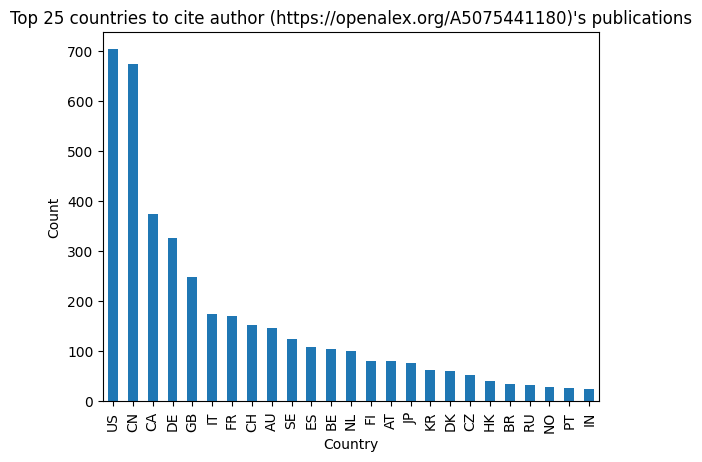

In [18]:
import matplotlib.pyplot as plt

# sort the dataframe by 'count' in descending order, select the top FIRST_NUM_ROWS rows, and plot as a bar chart
df_country_counts.sort_values(by="count", ascending=False).head(FIRST_NUM_ROWS).plot(kind="bar", legend=False)

# set the title of the plot
plt.title(f"Top {FIRST_NUM_ROWS} countries to cite author ({author_id})'s publications")
# set the x-axis label
plt.xlabel("Country")
# set the y-axis label
plt.ylabel("Count")

plt.show()

### Examine incoming citation counts by publisher

In a `work` entity object, there are information about the publisher ([`primary_location`](https://docs.openalex.org/api-entities/works/work-object#primary_location)) and the publication's APC listed by the publisher.  

`primary_location` is a [`Location`](https://docs.openalex.org/api-entities/works/work-object/location-object) object describing the primary location of this work. We are interested in the [`source`](https://docs.openalex.org/api-entities/works/work-object/location-object#source) of the location, which contains the information of the publisher, such as its OpenAlex `id` and `display_name`.  

Here, we create a dataframe displaying the number of times the researcher's work has been cited in different journals.  

In [19]:
import numpy as np

# extract 'id' from 'source' within 'primary_location' if 'source' exists; otherwise, set to null
df_incoming_referenced["source_id"] = df_incoming_referenced["primary_location"].apply(lambda location: location["source"]["id"] if location["source"] else np.nan)

# extract 'source_name' from 'source' within 'primary_location' if 'source' exists; otherwise, set to null
df_incoming_referenced["source_name"] = df_incoming_referenced["primary_location"].apply(lambda location: location["source"]["display_name"] if location["source"] else np.nan)

# fill null values in 'source_id' and 'source_name'
df_incoming_referenced["source_id"] = df_incoming_referenced["source_id"].fillna("unknown source")
df_incoming_referenced["source_name"] = df_incoming_referenced["source_name"].fillna("unknown source")

In [20]:
# group the dataframe by 'source_id' and 'source_name' and aggregate the 'id' column by count
df_publisher_counts = df_incoming_referenced.groupby(["source_id", "source_name"]).agg({"id": "count"})

# rename the 'id' column to 'count'
df_publisher_counts.rename(columns={"id": "count"}, inplace=True)

In [21]:
# top publishers to cite the author's publications
df_publisher_counts[df_publisher_counts.index != ("unknown source", "unknown source")].sort_values(by='count', ascending=False).head()

,,count
source_id,source_name,
https://openalex.org/S17729819,Agricultural and Forest Meteorology,206
https://openalex.org/S55737203,Journal of Hydrology,68
https://openalex.org/S4210238840,Journal of Geophysical Research Biogeosciences,68
https://openalex.org/S13442111,Biogeosciences,68
https://openalex.org/S43295729,Remote Sensing,57


## Open Access vs. Non-Open Access

Researcher's and research institutions want to maximize the impact of their research by selecting the most influential journals for their publications.  

Open access publications are more broadly accessible than their subscription-based counterparts. This leads us to wonder if open access publications at our institution are more highly cited than closed publcations.  

This kind of analysis can help organizations promote open access publishing by exploring the impact is has on citation rates.  

### Steps

1. We need to get all the works published by researchers at the institution
2. We get the publisher and open access status for each publication
3. We analyze the open access citation rate

### Input

For inputs, we first need to identify the Research Organization Registry (ROR) ID for our institution. In this example we will use the ROR ID for McMaster University ([https://ror.org/02fa3aq29](https://ror.org/02fa3aq29)). You can search and substitute your own institution's ROR here: [https://ror.org/search](https://ror.org/search).  

We also need to identify the publication year we are interested in analyzing.  

In [22]:
# input
ror_id = "https://ror.org/02fa3aq29"
publication_year = 2024

### Get all works published by researchers at the institution

Our search criteria are as follows:  
- [`institutions.ror`](https://docs.openalex.org/api-entities/works/work-object/authorship-object#institutions):  ROR ID of the institution affiliated with the authors of a work, `institutions.ror:https://ror.org/02fa3aq2`
- [`publication_year`](https://docs.openalex.org/api-entities/works/work-object#publication_year): the year the work was published, `publication_year:2024`

Now we need to build an URL for the query from the following parameters:
- Starting point is the base URL of the OpenAlex API: `https://api.openalex.org/`
- We append the entity type to it: `https://api.openalex.org/works`
- All criteria need to go into the query parameter filter that is added after a question mark: `https://api.openalex.org/works?filter=`
- To construct the filter value we take the criteria we specified and concatenate them using commas as separators: `https://api.openalex.org/works?filter=institutions.ror:https://ror.org/02fa3aq29,publication_year:2024&page=1&per-page=50`

In [23]:
def get_works_by_institution(ror_id, publication_year, page=1, items_per_page=50):
    # construct the api url with the given ror id, publication year, publication types, page number, and items per page
    url = f"https://api.openalex.org/works?filter=institutions.ror:{ror_id},publication_year:{publication_year}&page={page}&per-page={items_per_page}"

    # send a GET request to the api and parse the json response
    response = requests.get(url)
    json_data = response.json()

    # convert the json response to a dataframe
    df_json = pd.DataFrame.from_dict(json_data["results"])

    next_page = True
    if df_json.empty: # check if the dataframe is empty (i.e., no more pages available)
        next_page = False

    # if there are more pages, recursively fetch the next page
    if next_page:
        df_json_next_page = get_works_by_institution(ror_id, publication_year, page=page+1, items_per_page=items_per_page)
        df_json = pd.concat([df_json, df_json_next_page])

    return df_json

In [ ]:
df_works = get_works_by_institution(ror_id, publication_year)
if SAVE_CSV:
    df_works.to_csv(f"institution_works_{publication_year}.csv", index=True)

### Get Publishers and Open Access Status

In a `work` entity object, there are information about the publication's access status ([`open_access`](https://docs.openalex.org/api-entities/works/work-object#open_access)) and the publisher (`primary_location`).  

`open_access` is a [`OpenAccess`](https://docs.openalex.org/api-entities/works/work-object#the-openaccess-object) object describing the access status of this work. The object contains Open Access status of this work (`oa_status`) with the following possible values:  


- [`diamond`](https://en.wikipedia.org/wiki/Diamond_open_access): Published in a fully OA journal—one that is indexed by the [Directory of Open Access Journals (DOAJ)](https://doaj.org/) or that we have determined to be OA—with no article processing charges (i.e., free for both readers and authors).
- `gold`: Published in a fully OA journal.
- `green`: Toll-access on the publisher landing page, but there is a free copy in an [OA repository](https://en.wikipedia.org/wiki/Open-access_repository).
- `hybrid`: Free under an [open license](https://support.unpaywall.org/support/solutions/articles/44002063718-what-is-an-oa-license-) in a toll-access journal.
- `bronze`: Free to read on the publisher landing page, but without any identifiable license.
- `closed`: All other articles.

In [25]:
import numpy as np

# extract 'oa_status' from the 'open_access' dictionary for each row
df_works["oa_status"] = df_works["open_access"].apply(lambda open_access: open_access["oa_status"])

# extract 'id' from 'source' within 'primary_location' if 'source' exists; otherwise, set to null
df_works["source_id"] = df_works["primary_location"].apply(lambda location: location["source"]["id"] if location["source"] else np.nan)

# extract 'source_name' from 'source' within 'primary_location' if 'source' exists; otherwise, set to null
df_works["source_name"] = df_works["primary_location"].apply(lambda location: location["source"]["display_name"] if location["source"] else np.nan)

# extract total citation counts for each row
df_works["total_citation"] = df_works["counts_by_year"].apply(lambda citation_count_by_year: sum([count["cited_by_count"] for count in citation_count_by_year]))

# fill null values in 'source_id' and 'source_name'
df_works["source_id"] = df_works["source_id"].fillna("unknown source")
df_works["source_name"] = df_works["source_name"].fillna("unknown source")

### Aggregate Data Analysis

Here, we create a dataframe that summarizes our institution's citation rates by Open Access type (e.g. Gold, Bronze, Green, etc.).

In this case, both Gold and Hybrid OA publications are cited at a significantly higher rate than Closed access publications. This suggests that publishing in these types of open access journals could increase the influence of your work.  

In [26]:
# group the dataframe by 'oa_status' and aggregate the 'id' column by count and 'total_citation' column by sum
df_oa = df_works.groupby(["oa_status"]).agg({"id": "count", "total_citation": "sum"})

# rename the 'id' column to 'count'
df_oa.rename(columns={"id": "count"}, inplace=True)

# calculate the citation rate by dividing 'total_citation' by 'id' and add it as a new column
df_oa["citation_rate"] = df_oa["total_citation"] / df_oa["count"]

df_oa

,count,total_citation,citation_rate
oa_status,,,
bronze,245,376,1.534694
closed,2960,3741,1.263851
diamond,247,270,1.093117
gold,1751,2501,1.428327
green,664,591,0.890060
hybrid,1412,3021,2.139518


In [27]:
# group the dataframe by 'oa_status' and count the number of occurrences of each 'oa_status'
df_oa = df_works.groupby(["source_id", "source_name", "oa_status"]).agg({"id": "count"})

# reset the index to have 'source_name' and 'oa_status' as columns
df_oa = df_oa.reset_index()

# pivot the dataframe to have 'source_name' as index, 'oa_status' as columns and count as values
df_oa = df_oa.pivot(index="source_name", columns="oa_status", values="id")

In [28]:
if SAVE_CSV:
    df_oa.to_csv(f"institution_works_oa_{publication_year}.csv", index=True)

df_oa

oa_status,bronze,closed,diamond,gold,green,hybrid
source_name,,,,,,
2021 IEEE 94th Vehicular Technology Conference (VTC2021-Fall),NaN,1.0,NaN,NaN,NaN,NaN
2021 IEEE Asia-Pacific Microwave Conference (APMC),NaN,1.0,NaN,NaN,NaN,NaN
2021 IEEE International Conference on Big Data (Big Data),NaN,NaN,NaN,NaN,1.0,NaN
"2022 11th International Conference on Control, Automation and Information Sciences (ICCAIS)",NaN,1.0,NaN,NaN,NaN,NaN
2022 16th European Conference on Antennas and Propagation (EuCAP),NaN,1.0,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...
unknown source,53.0,216.0,NaN,4.0,245.0,22.0
The journal of academic science.,NaN,NaN,NaN,NaN,NaN,1.0
"The minerals, metals & materials series",NaN,1.0,NaN,NaN,NaN,NaN


### Identifying our institution's most popular publication sources (by open access status)

#### Gold Open Access

In [29]:
# top 5 publications with most 'gold' 'oa_status'
df_oa[df_oa.index != "unknown source"].sort_values("gold", ascending=False).head()

oa_status,bronze,closed,diamond,gold,green,hybrid
source_name,,,,,,
PLoS ONE,NaN,NaN,NaN,111.0,NaN,NaN
Journal of the Canadian Association of Gastroenterology,NaN,NaN,NaN,49.0,NaN,NaN
BMJ Open,NaN,NaN,NaN,49.0,NaN,NaN
Scientific Reports,NaN,NaN,NaN,40.0,NaN,NaN
JAMA Network Open,NaN,NaN,NaN,29.0,NaN,NaN


#### Diamond Open Access

In [30]:
# top 5 publications with most 'diamond' 'oa_status'
df_oa[df_oa.index != "unknown source"].sort_values("diamond", ascending=False).head()

oa_status,bronze,closed,diamond,gold,green,hybrid
source_name,,,,,,
Genetics in Medicine Open,NaN,NaN,9.0,NaN,NaN,NaN
Canadian Medical Education Journal,NaN,NaN,8.0,NaN,NaN,NaN
Campbell Systematic Reviews,NaN,NaN,6.0,NaN,NaN,NaN
Studies in Social Justice,NaN,NaN,6.0,NaN,NaN,NaN
Frontiers in Health Services,NaN,NaN,5.0,NaN,NaN,NaN


#### Closed Access

In [31]:
# top 5 publications with most 'closed' 'oa_status'
df_oa[df_oa.index != "unknown source"].sort_values("closed", ascending=False).head()

oa_status,bronze,closed,diamond,gold,green,hybrid
source_name,,,,,,
Blood,1.0,60.0,NaN,NaN,NaN,1.0
Journal of Clinical Oncology,NaN,37.0,NaN,NaN,1.0,1.0
Journal of Obstetrics and Gynaecology Canada,2.0,30.0,NaN,NaN,NaN,6.0
Springer eBooks,NaN,28.0,NaN,NaN,NaN,NaN
Elsevier eBooks,NaN,25.0,NaN,NaN,NaN,NaN
